In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!ls "/content/gdrive/My Drive/data"

Mounted at /content/gdrive
face.csv	      faceDataset2	  model4sexClassfierWithoutValid
faceData	      faceDataWithNumber  rawdata
faceData2D	      faceDR		  vgg_face_dag.pth
faceData2DWithNumber  faceDS
faceDataset	      faceLabel.csv


In [ ]:
import matplotlib.pyplot as plt  # show image
import numpy as np
import pandas as pd
import sys
import tensorflow as tf

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
dtype = np.uint8
shape = (128,128)

# file_path /content/gdrive/My Drive/data/rawdata/xxxx
pre_img_path="/content/gdrive/My Drive/data/rawdata/"
pre_path="/content/gdrive/My Drive/data/"

# Read the data from the binary file
# data = np.fromfile(file_path, dtype=dtype).reshape(shape)

In [ ]:


# def readImage(path):
#     with open(path,'rb') as f:
#         # print(path)
#         data = np.fromfile(f, dtype=np.uint8)
#         image_array=np.reshape(data,(128,128))
#         return image_array
#         # return data
    
face=pd.read_csv(pre_path+"faceLabel.csv")

# save part
new=True
for  i in face["number"]:
    # number=1223
    if new==True:
        path=pre_path+f"rawdata/{i}"
        new_element = np.fromfile(path, dtype=dtype).reshape(shape)
        dataset = tf.data.Dataset.from_tensor_slices([new_element])
        new=False
    else:
        path=pre_path+f"rawdata/{i}"
        data = np.fromfile(path, dtype=dtype).reshape(shape)
        new_element = tf.data.Dataset.from_tensor_slices([data])
        dataset = dataset.concatenate(new_element)
    # if i>1230:
    #     break
# print(faceData.shape)
# faceData.to_pickle("faceData2D") 
print(dataset)


# print(faceData)

# plt.imshow(np.reshape(faceData.iloc[0,1],(128,128)), cmap='cividis', vmin=0, vmax=256)
# plt.show()

<_ConcatenateDataset element_spec=TensorSpec(shape=(128, 128), dtype=tf.uint8, name=None)>


In [ ]:
# tf.data.experimental.save(dataset, pre_path+"faceDataset")

In [ ]:
num_elements = tf.data.experimental.cardinality(dataset).numpy()

print(f"The concatenated dataset has {num_elements} elements.")

The concatenated dataset has 3993 elements.


In [ ]:
def convert_image(image):
    image = tf.expand_dims(image, axis=0)
    image = tf.expand_dims(image, axis=-1)
    return tf.tile(image, [1, 1, 1, 3])
dataset_ = dataset.map(convert_image)

In [ ]:
print(dataset_)

<_MapDataset element_spec=TensorSpec(shape=(1, 128, 128, 3), dtype=tf.uint8, name=None)>


In [ ]:
# def add_batch_dimension(image):
#     return tf.expand_dims(image, axis=0)
# dataset_ = dataset_.map(convert_image)

In [ ]:
# convert dataframe to tensor
label_tensor=tf.convert_to_tensor(face["sex_label"].values)

In [ ]:
label_tensor_=tf.data.Dataset.from_tensor_slices(label_tensor)

In [ ]:
label_tensor_=tf.reshape(label_tensor,(num_elements,1))
label_tensor_=tf.data.Dataset.from_tensor_slices(label_tensor_)

In [ ]:
print(label_tensor_)
# print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.int64, name=None)>


In [ ]:
# merge label and data
data_=tf.data.Dataset.zip((dataset_,label_tensor_))
# data_=tf.stack([dataset,label_tensor_.take(8)])

In [ ]:
# tf.data.experimental.save(data_, pre_path+"face_Dataset")

In [ ]:
print(data_)

<_ZipDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [ ]:
# split train and test sets
# 计算训练集大小（例如，80% 的数据用于训练）
train_size = int(num_elements * 0.8)

# 使用 take 方法获取训练集
ds_train_ = data_.take(train_size)

# 使用 skip 方法获取测试集
ds_valid_ = data_.skip(train_size)

In [ ]:
print(ds_valid_)

<_SkipDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [ ]:
# Data Pipeline
def convert_to_float(image,label ):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(1, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:
# ds_valid
num_elements1 = tf.data.experimental.cardinality(ds_train_).numpy()

print(f"The concatenated ds_train has {num_elements1} elements.")

The concatenated ds_train has 3194 elements.


The **InceptionV1** model pretrained on ImageNet is available in the [TensorFlow Hub](https://www.tensorflow.org/hub/) repository, but we'll load it from a local copy. Run this cell to load InceptionV1 for your base.

In [ ]:
# !pip install mmdnn

In [ ]:
# !mmconvert -sf pytorch -in http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth -df tensorflow -om /content/gdrive/data/vgg_face.pb   

In [ ]:
import tensorflow_hub as hub

# pretrained_base = tf.keras.models.load_model(
#     '/content/gdrive/My Drive/data/vgg_face.pb'
# )
# pretrained_base = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5")
pretrained_base = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5")

# 1) Define Pretrained Base #

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [ ]:
# YOUR_CODE_HERE
pretrained_base.trainable = False



In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

# 2) Attach Head #

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/i5VU7Ry.png" alt="Diagram of the dense head.">
</figure>


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    # YOUR CODE HERE. Attach a head of dense layers.
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


# 3) Train #

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **binary classification** problem: `Car` coded as 0, and `Truck` coded as 1. Choose an appropriate loss and an appropriate accuracy metric for binary classification.

In [ ]:
# YOUR CODE HERE: what loss function should you use for a binary
# classification problem? (Your answer for each should be a string.)
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint('model-{epoch:02d}.h5', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/30
3194/3194 [==============================] - 55s 13ms/step - loss: 0.6052 - binary_accuracy: 0.6437 - val_loss: 0.6452 - val_binary_accuracy: 0.4343
Epoch 2/30
3194/3194 [==============================] - 29s 9ms/step - loss: 0.6306 - binary_accuracy: 0.5398 - val_loss: 0.6356 - val_binary_accuracy: 0.4143
Epoch 3/30
3194/3194 [==============================] - 28s 9ms/step - loss: 0.5705 - binary_accuracy: 0.6800 - val_loss: 0.5246 - val_binary_accuracy: 0.7234
Epoch 4/30
3194/3194 [==============================] - 28s 9ms/step - loss: 0.4063 - binary_accuracy: 0.8507 - val_loss: 0.5000 - val_binary_accuracy: 0.7447
Epoch 5/30
3194/3194 [==============================] - 28s 9ms/step - loss: 0.3684 - binary_accuracy: 0.8582 - val_loss: 0.4876 - val_binary_accuracy: 0.7610
Epoch 6/30
3194/3194 [==============================] - 29s 9ms/step - loss: 0.3489 - binary_accuracy: 0.8635 - val_loss: 0.4824 - val_binary_accuracy: 0.7722
Epoch 7/30
3194/3194 [=======================

Run the cell below to plot the loss and metric curves for this training run.

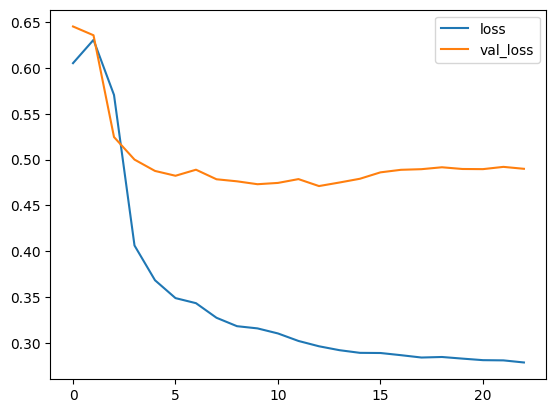

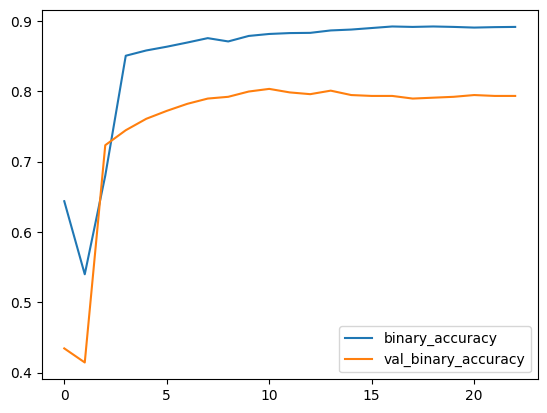

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
# # 定义输入和输出
# inputs = {'input_image': model.input}
# outputs = {'output_scores': model.output}

# 导出模型
tf.saved_model.save(model, pre_path+"model4sexClassfier")

`History` 对象本身并不保存模型的权重。它只记录了模型训练过程中的损失值和评估指标。如果您想要保存模型的权重，您可以使用 `ModelCheckpoint` 回调或者在训练结束后手动调用 `save_weights` 方法。

例如，下面的代码展示了如何使用 `ModelCheckpoint` 回调来保存模型的权重。

```python
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('weights.h5', save_weights_only=True)
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[checkpoint])
```

在上面的代码中，`ModelCheckpoint` 回调会在每一轮训练后保存模型的权重。您可以通过修改文件名来控制保存文件的命名方式。

此外，您还可以在训练结束后手动调用 `save_weights` 方法来保存模型的权重。例如，下面的代码展示了如何在训练结束后保存模型的权重。

```python
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
model.save_weights('weights.h5')
```

在上面的代码中，`save_weights` 方法会将模型的权重保存到指定的文件中。您可以在之后使用 `load_weights` 方法来加载保存的权重。